## 双人零和博弈纳什均衡的求解

本实验将使用 Multiplicative Weights Update (MWU) 算法和线性规划 (LP) 方法求解双人零和博弈的纳什均衡，并且验证两种算法的正确性。

### 注意事项

0. **这是本实验应该看的第一个文件，请根据本文件的指示，逐步完成实验**
1. 本实验需要填空的文件夹为 support.py，mwu_solver.py 和 nash_verifier.py，**请不要修改其他文件，包括本 ipynb 文件**
2. 完成三个文件函数代码的实现后，在以下每个代码框中验证计算结果
3. 在实验过程中，**允许使用生成式人工智能理解代码框架并完成实验**
4. **提交时需要将整个代码文件夹压缩成 .zip 格式提交，并且注意保留本 ipynb 文件的所有运行结果**，不要清除输出

文件内容解释：

- dataset: 包含石头剪刀布游戏以及两个随机生成游戏的收益矩阵
- game_generator.py：生成博弈数据集的代码文件，无需修改；
- homework.ipynb: 运行测试且最后提交的文件；
- support.py: 待补充，枚举支撑集并且通过线性约束求解纳什均衡的代码；
- mwu_solver.py: 待补充，使用 Multiplicative Weights Update 算法计算纳什均衡的代码；
- nash_verifier.py: 待补充，验证计算出的纳什均衡是否正确；
- zero_sum_game.py: 定义了零和博弈的类，无需修改。

### 实验目标

1. 理解双人零和博弈的基本概念
2. 掌握 MWU 算法的原理和代码实现
3. 掌握使用线性可行性（linear feasibility）精确求解零和博弈纳什均衡的方法
4. 利用求解纳什博弈是 NP 问题，使用多项式方法检验均衡解的正确性

### 实验环境设置

根据 `requirements.txt` 文件，安装所需的库。

```bash
pip install -r requirements.txt
```

### 生成博弈数据集

我们在课堂中学过了双人零和博弈的矩阵表达：假设博弈的收益矩阵为 A，行玩家和列玩家的策略分别为 x 和 y，那么行玩家的收益为 $x^T A y$，列玩家的收益为 $-x^T A y$。

在这里我们生成了石头剪刀布以及两个随机游戏的收益矩阵，其中石头剪刀布的收益矩阵如下：

| 行玩家\列玩家 | 石头 | 剪刀 | 布 |
|--------------|------|------|-----|
| 石头         |  0   |  1   | -1  |
| 剪刀         | -1   |  0   |  1  |
| 布           |  1   | -1   |  0  |

**其中：**
- 行玩家选择行，列玩家选择列，矩阵中的数值表示行玩家的收益
- 1 表示行玩家获胜
- -1 表示行玩家失败  
- 0 表示平局
- 列玩家的收益矩阵为行玩家收益矩阵的负数（零和博弈）

In [1]:
from game_generator import GameGenerator
generator = GameGenerator()
games = generator.generate_all_games()

print("Games Generated:")
for name, game in games.items():
    print(f"Game Name: {name}")
    print(f"Payoff Matrix: {game.payoff_matrix}")

开始生成博弈数据集...
博弈矩阵保存到: dataset\rock_paper_scissors.txt
生成石头剪刀布博弈矩阵 (3 x 3)
博弈矩阵保存到: dataset\random_5x5.txt
生成 5 x 5 随机博弈矩阵
博弈矩阵保存到: dataset\random_10x10.txt
生成 10 x 10 随机博弈矩阵

生成完成！共生成 3 个博弈，保存在 dataset 目录
Games Generated:
Game Name: rock_paper_scissors
Payoff Matrix: [[ 0.  1. -1.]
 [-1.  0.  1.]
 [ 1. -1.  0.]]
Game Name: random_5x5
Payoff Matrix: [[ 3.42 -3.8   2.31  0.56 -1.19]
 [-3.18  3.71  0.2  -2.08  1.59]
 [ 0.7   1.72  0.76  3.28 -4.86]
 [ 1.42 -4.84 -3.4  -1.39  4.99]
 [-0.57 -1.15 -2.36 -0.83  0.4 ]]
Game Name: random_10x10
Payoff Matrix: [[ 6.84 -7.6   4.63  1.12 -2.37 -6.35  7.42  0.41 -4.17  3.17]
 [ 1.39  3.43  1.52  6.57 -9.71  2.83 -9.68 -6.8  -2.79  9.97]
 [-1.14 -2.3  -4.72 -1.65  0.79 -0.87  4.43  2.71  9.36  6.62]
 [-3.8   0.87  6.1  -7.25  5.98  2.83 -1.83 -8.45 -4.37 -4.49]
 [ 3.27 -0.97 -5.98 -1.1  -2.02 -2.33  2.28  1.52 -9.66  2.14]
 [-7.7   5.76 -9.   -8.   -2.03  0.05 -5.98 -2.66  4.63  3.48]
 [ 3.13  0.83  7.11  8.39 -0.41 -8.    7.14 -4.39  9.33 -5.65]
 [-

### 任务一：完成纳什均衡检验器

在正式求解纳什均衡之前，我们首先先要实现一个纳什均衡检验器，来验证我们求解出的纳什均衡是否正确。

假设玩家 $A,B$ 的混合策略 $X,Y$ 达到了纳什均衡，那么他们都没有动机单方面改变自己的策略，即：

\begin{align*}
u_A(X,Y) \geqslant u_A(x,Y) \quad \forall x \in \Delta(A) \\
u_B(X,Y) \geqslant u_B(X,y) \quad \forall y \in \Delta(B)
\end{align*}

因为任意混合策略都是纯策略的线性组合，所以我们只要保证对于任意纯策略 $e_i \in R^n,e_j \in R^m$，都有：

\begin{align*}
u_A(e_i,Y) \leqslant u_A(X,Y) \\
u_B(X,e_j) \leqslant u_B(X,Y)
\end{align*}

请同学们根据以上定义，完成 `nash_verifier.py` 文件中的 `is_equilibrium` 函数。

完成以后，可以运行以下代码验证纳什均衡检验器的正确性：

**提示：**
- 在课上已经讲过，如果行、列玩家的混合策略分别是 $x,y$，博弈的收益矩阵为 $A$，那么 $u_A(x,y) = x^T A y$，$u_B(x,y) = -x^T A y$
- 在实验中我们引入了 `numpy` 库，同学们可以直接使用 `@` 符号来计算矩阵乘法，即计算 `x @ A @ y` 得到 $x^T A y$ 的值

In [2]:
from nash_verifier import NashVerifier
import numpy as np

# 剪刀石头布收益矩阵
payoff = np.array([
    [0, -1, 1],
    [1, 0, -1],
    [-1, 1, 0]
])

# 创建验证器
verifier = NashVerifier(payoff)

# 测试均衡策略
x = np.array([1/3, 1/3, 1/3])  # 行玩家策略
y = np.array([1/3, 1/3, 1/3])  # 列玩家策略

print(verifier.is_equilibrium(x, y))  # 输出 True

# 测试非均衡策略
x_bad = np.array([1, 0, 0])  # 行玩家总是出石头
print(verifier.is_equilibrium(x_bad, y))  # 输出 False

True
False


### 任务二：通过枚举支撑集来求解博弈

对于博弈 $G$，假如一个玩家的策略空间是 $n$ 维的，其混合策略为 $X = (x_1, x_2, \cdots, x_n)$，定义这个玩家此策略的支撑集 $S = \{i \mid x_i > 0\}$。

假如对于玩家 $A,B$，我们已经知道当双方达到纳什均衡的时候，他们的混合策略 $X,Y$ 的支撑集 $S_1=(s_1,s_2,\cdots,s_p), S_2=(t_1,t_2,\cdots,t_q)$，我们有一个重要的结论：**每个人的支撑集中的元素一定是最优反应，而支撑集外的元素收益不能超过支撑集内的元素。**

#### 线性可行性问题表述

因此，如果我们知道双方的支撑集具体是什么的话，纳什均衡可以表述为一个**线性可行性问题**，变量为 $x_1^*, x_2^*, U_1, U_2$，其中：
- $x_1^*$ 是玩家 1 的混合策略
- $x_2^*$ 是玩家 2 的混合策略  
- $U_1, U_2$ 分别是两个玩家的期望收益

约束条件包括：

**等式约束：**

1. **概率归一化约束：**
   $$\sum_{i \in [m]} x_1^*(i) = 1, \quad \sum_{j \in [n]} x_2^*(j) = 1$$

2. **支撑集内策略收益相等：**
   - 对于玩家 1：$\forall i \in S_1: \sum_{j \in S_2} u_1(i,j) x_2^*(j) = U_1$
   - 对于玩家 2：$\forall j \in S_2: \sum_{i \in S_1} u_2(i,j) x_1^*(i) = U_2$

3. **支撑集外策略概率为零：**
   - $\forall i \notin S_1: x_1^*(i) = 0$
   - $\forall j \notin S_2: x_2^*(j) = 0$

**不等式约束：**

4. **支撑集外策略收益不超过支撑集内：**
   - 对于玩家 1：$\forall i \notin S_1: \sum_{j \in S_2} u_1(i,j) x_2^*(j) \leqslant U_1$
   - 对于玩家 2：$\forall j \notin S_2: \sum_{i \in S_1} u_2(i,j) x_1^*(i) \leqslant U_2$

5. **概率非负约束：**
   $$\forall i \in [m]: x_1^*(i) \geq 0, \quad \forall j \in [n]: x_2^*(j) \geq 0$$

#### 算法流程

1. **枚举所有可能的支撑集组合** $(S_1, S_2)$
2. **构建线性可行性问题**：
   - 设置变量：$[x_1^*(1), \ldots, x_1^*(m), x_2^*(1), \ldots, x_2^*(n), U_1, U_2]$
   - 添加上述等式和不等式约束
3. **使用线性规划求解器**求解可行性问题
4. **验证解的有效性**：检查是否为真正的纳什均衡
5. **输出所有找到的纳什均衡**

接下来请同学们在 `support.py` 文件中完成线性可行性问题的构建，然后运行以下代码，读取 `dataset` 文件夹中的收益矩阵，求解纳什均衡，并且验证均衡正确性。

**提示：**

- 使用 `scipy.optimize.linprog` 求解线性规划问题，在 `support.py` 中我们已经给出了具体的调用方法；
- 线性规划的标准形式是最小化问题，但我们只需要找可行解，所以目标函数可以设为零向量；
- 请同学们根据提示完成 `_solve_support` 函数，填写等式约束和不等式约束；
- 因为这个算法的复杂度是指数级的，所以运行时间可能相对较长，请同学们耐心等待。

In [3]:
import numpy as np
import os
from support import NashSolver  
from nash_verifier import NashVerifier

def load_payoff_matrix(filepath):
    """从文本文件加载收益矩阵（适配新格式）"""
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            # 跳过空行和注释行（以#开头的行）
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            # 分割行并转换为浮点数
            row = list(map(float, line.split()))
            data.append(row)
    return np.array(data)

def print_results(results, payoff_matrix):
    if not results:
        print("No Nash equilibria found.")
        return
    
    # 创建验证器
    verifier = NashVerifier(payoff_matrix)
    
    for i, (row_supp, col_supp, x, y, v) in enumerate(results, 1):
        print(f"=== Equilibrium {i} ===")
        print(f"Row support (indices): {row_supp}")
        print(f"Col support (indices): {col_supp}")
        print("Row strategy (probabilities):")
        print("\n".join([f"  Strategy {idx}: {prob:.6f}" 
                        for idx, prob in enumerate(x) if prob > 1e-6]))
        print("Col strategy (probabilities):")
        print("\n".join([f"  Strategy {idx}: {prob:.6f}" 
                        for idx, prob in enumerate(y) if prob > 1e-6]))
        print(f"Value (row player's payoff): {v:.6f}")
        
        # 验证是否为合法的纳什均衡
        is_valid = verifier.is_equilibrium(x, y)
        print(f"Valid Nash Equilibrium: {'Yes' if is_valid else 'No'}")
        print()

def process_game_files():
    """处理所有游戏文件"""
    input_dir = "dataset"
    game_files = [
        "random_5x5.txt",
        "random_10x10.txt", 
        "rock_paper_scissors.txt"
    ]
    
    for filename in game_files:
        print(f"\nProcessing {filename}...")
        filepath = os.path.join(input_dir, filename)
        
        try:
            # 加载收益矩阵
            payoff_matrix = load_payoff_matrix(filepath)
            print(payoff_matrix)
            
            # 求解纳什均衡
            solver = NashSolver(payoff_matrix)
            results = solver.find_all_equilibria()
            
            # 打印结果并验证
            print_results(results, payoff_matrix)
            
        except FileNotFoundError:
            print(f"Error: File {filename} not found in {input_dir}/")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")

if __name__ == "__main__":
    print("=== Nash Equilibrium Solver ===")
    process_game_files()
    print("\nAll files processed!")

=== Nash Equilibrium Solver ===

Processing random_5x5.txt...
[[ 3.42 -3.8   2.31  0.56 -1.19]
 [-3.18  3.71  0.2  -2.08  1.59]
 [ 0.7   1.72  0.76  3.28 -4.86]
 [ 1.42 -4.84 -3.4  -1.39  4.99]
 [-0.57 -1.15 -2.36 -0.83  0.4 ]]
=== Equilibrium 1 ===
Row support (indices): (0, 1, 2, 3)
Col support (indices): (1, 2, 3, 4)
Row strategy (probabilities):
  Strategy 0: 0.187680
  Strategy 1: 0.336318
  Strategy 2: 0.271538
  Strategy 3: 0.204463
Col strategy (probabilities):
  Strategy 1: 0.076309
  Strategy 2: 0.201458
  Strategy 3: 0.397751
  Strategy 4: 0.324482
Value (row player's payoff): 0.012001
Valid Nash Equilibrium: Yes


Processing random_10x10.txt...
[[ 6.84 -7.6   4.63  1.12 -2.37 -6.35  7.42  0.41 -4.17  3.17]
 [ 1.39  3.43  1.52  6.57 -9.71  2.83 -9.68 -6.8  -2.79  9.97]
 [-1.14 -2.3  -4.72 -1.65  0.79 -0.87  4.43  2.71  9.36  6.62]
 [-3.8   0.87  6.1  -7.25  5.98  2.83 -1.83 -8.45 -4.37 -4.49]
 [ 3.27 -0.97 -5.98 -1.1  -2.02 -2.33  2.28  1.52 -9.66  2.14]
 [-7.7   5.76 -9.   

### 任务三：使用 MWU 算法求解博弈

Multiplicative Weights Update (MWU) 算法是一种在线学习算法，可以用来近似求解双人零和博弈的纳什均衡。算法的核心思想是：

1. **初始化权重**：两个玩家都从均匀分布开始
2. **迭代更新**：在每轮中：
    - 根据当前权重计算混合策略: $x_i^{(t + 1)} = \dfrac{w_i^{(t)}}{\sum_{j = 1}^n w_j^{(t)}}$
    - 给出每个玩家的 `cost` 向量
    - 使用乘性规则更新权重：$w_i^{(t + 1)} = w_i^{(t)} \times (1 - \epsilon \times \text{cost}_i^{(t)})$

回忆课上讲到的遗憾定义，记:
$$
Regret_{row} = \max_i \sum_{t = 1}^T U(i, y_t) - \sum_{t = 1}^T U(x_t, y_t) \\
Regret_{col} = \sum_{t = 1}^T U(x_t, y_t) - \min_j \sum_{t = 1}^T U(x_t, j)
$$
注意对列参与人而言，$U$ 是效用的负值，因此可以视为成本，故与课上情况一致，表达式也一致；但对于行参与人而言，$U$ 就是效用，因此是奖励，故需要使用对称版本的表达式表示遗憾（事后固定行动最大奖励减去期望奖励）。

从理论上讲，如果双方都使用 MWU 算法，在零和博弈的背景下可以互相为对方提供成本/奖励，当经过足够多轮以后，$Regret_{row} / T$ 和 $Regret_{col} / T$ 会趋近于 0，从而找到纳什均衡（如果想要理解为什么会收敛到纳什均衡，可以参考[这份 slides 的 14-21 页](https://www.haifeng-xu.com/cmsc35401win24/slides/lec8-mwu.pdf)，当然可以默认这一点成立）。然而，在现实的场景下，双方都使用 MWU 会导致双方的收敛到纳什均衡速度很慢，与此同时如果进行过多轮迭代会导致 $w$ 向量产生精度误差，很难真正实现收敛，因此下面需要实现的是只有一方进行学习的方法：

1. **列玩家作为学习者**，在游戏最开始时随机选择策略，即设置权重向量 $w$ 同一个值；
2. **行玩家作为对抗者**，在每一轮中，**针对列玩家当前的策略，选择使得自己期望收益最大的策略**（因为是零和博弈，也就是使得列玩家收益最小（成本最大）的策略，符合对抗性多臂老虎机的成本特点）；
3. 根据行玩家的对抗策略，计算列玩家的 $cost_i^{(t)}$ 向量，具体来讲，假如上一轮行玩家的策略为 $x$，那么 $cost_i^{(t)} = -u_B(x, i) = u_A(x, i)$；
4. 使用乘性规则更新权重：$w_i^{(t + 1)} = w_i^{(t)} \times (1 - \epsilon \times \text{cost}_i^{(t)})$；
5. 在新的一轮中，列玩家根据 $w$ 向量计算新的混合策略，即 $y_i^{(t + 1)} = \dfrac{w_i^{(t)}}{\sum_{j = 1}^n w_j^{(t)}}$，不断迭代直到收敛。

最后经过多轮的对抗，列玩家的策略收敛到纳什均衡策略；而对于行玩家，在迭代过程中，我们记录每一轮行玩家的最佳反应，记 $T$ 轮迭代中（$T$ 足够大）行参与人的纯策略 $i$ 一共作为最优反应被执行了 $n_i$ 次，计算 $x_i = \dfrac{n_i}{T}$ 就是行参与人的纳什均衡策略。下面简单解释为什么上述算法可以收敛到零和博弈纳什均衡（可以不看）：因为列玩家进行的是无憾算法，所以理论上可以证明列玩家的策略可以收敛到其纳什均衡对应的策略；对于行玩家则可以从**列玩家收敛**的角度来反推行参与人的纳什均衡：因为列玩家在不断学习行玩家的策略，并且改变自己的策略，所以只有当行玩家在统计意义上以纳什均衡的概率来选择策略时，列玩家才没有动机去偏移自己当前的策略，因此行参与人的策略就是纳什均衡的策略解（总而言之，纳什均衡的要求是互为最优反应）。

请同学们在 `mwu_solver.py` 文件中完成MWU算法的实现，然后执行以下代码，检验最终结果是否是纳什均衡，并且绘制列玩家在学习过程中的遗憾值收敛图。

**提示：**

- `mwu_solver.py` 文件中已经完成了大部分代码，同学们只需要完成 `find_equilibrium` 函数中列玩家和行玩家选择策略的部分。
- 在计算 $cost$ 向量时，同学们需要注意要保证 $cost_i^{(t)} \in [0, 1]$，为了方便起见，我们已经在 MWU 算法中对于收益矩阵进行了归一化，即收益矩阵中的每一个元素都在 $[0, 1]$ 之间。
- `max_iter` 参数可以按需修改，但如果过大可能会导致精度问题；`epsilon` 参数是严格的 $\sqrt{\dfrac{\log n}{T}}$，同学们可以参考课上推导的公式。


测试 rock_paper_scissors.txt
博弈规模: (3, 3)
收益矩阵:
[[ 0.  1. -1.]
 [-1.  0.  1.]
 [ 1. -1.  0.]]

结果:
  行玩家策略: [0.964906 0.017546 0.017548]
  列玩家策略: [0.333333 0.333333 0.333333]
  博弈值: 0.000000
  Valid Nash Equilibrium: No

绘制 rock_paper_scissors.txt 的收敛图:


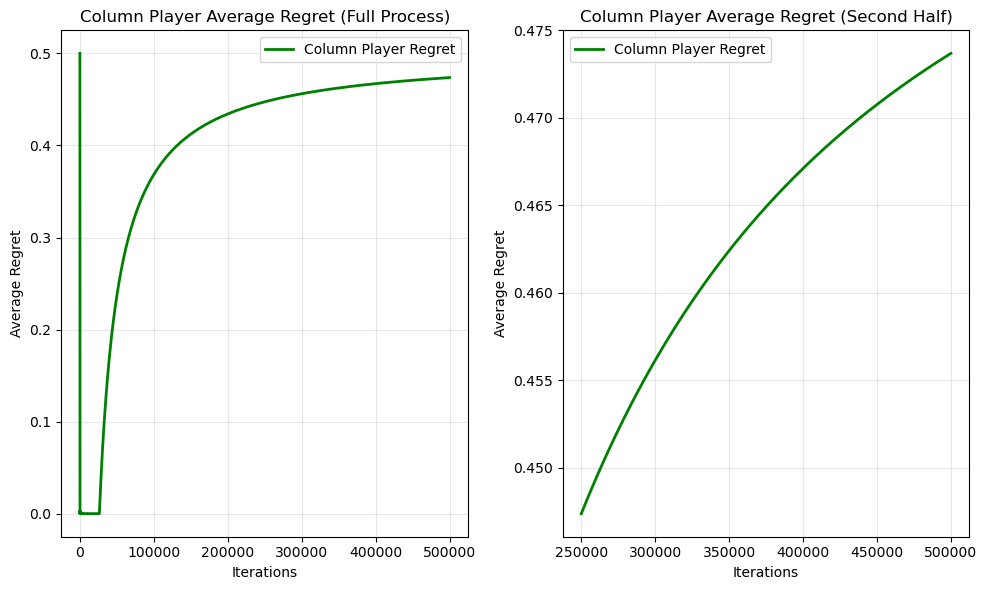


测试 random_5x5.txt
博弈规模: (5, 5)
收益矩阵:
[[ 3.42 -3.8   2.31  0.56 -1.19]
 [-3.18  3.71  0.2  -2.08  1.59]
 [ 0.7   1.72  0.76  3.28 -4.86]
 [ 1.42 -4.84 -3.4  -1.39  4.99]
 [-0.57 -1.15 -2.36 -0.83  0.4 ]]

结果:
  行玩家策略: [0.009824 0.015838 0.966404 0.007934 0.      ]
  列玩家策略: [0.2 0.2 0.2 0.2 0.2]
  博弈值: 0.307454
  Valid Nash Equilibrium: No

绘制 random_5x5.txt 的收敛图:


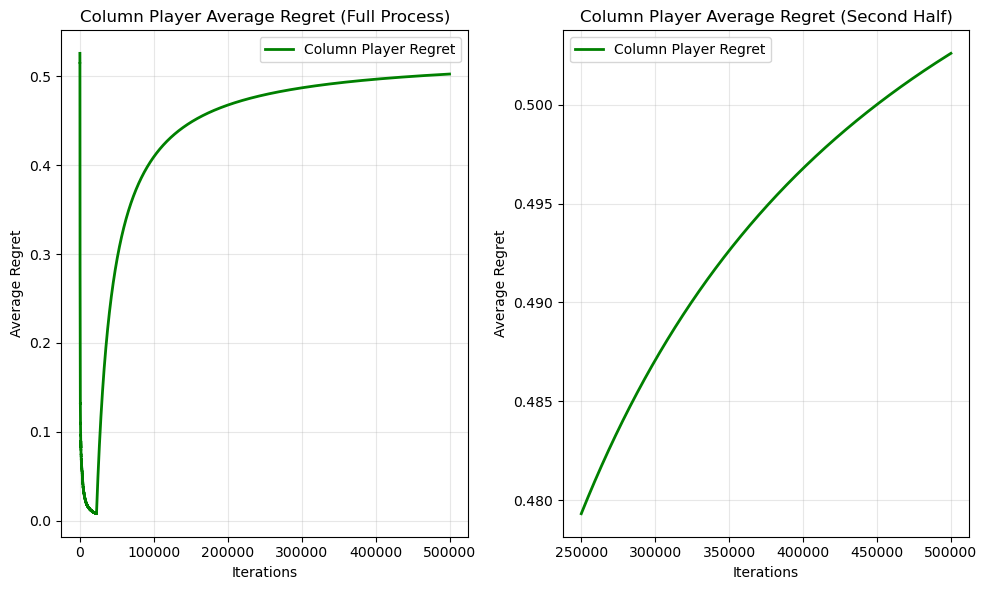


测试 random_10x10.txt
博弈规模: (10, 10)
收益矩阵:
[[ 6.84 -7.6   4.63  1.12 -2.37 -6.35  7.42  0.41 -4.17  3.17]
 [ 1.39  3.43  1.52  6.57 -9.71  2.83 -9.68 -6.8  -2.79  9.97]
 [-1.14 -2.3  -4.72 -1.65  0.79 -0.87  4.43  2.71  9.36  6.62]
 [-3.8   0.87  6.1  -7.25  5.98  2.83 -1.83 -8.45 -4.37 -4.49]
 [ 3.27 -0.97 -5.98 -1.1  -2.02 -2.33  2.28  1.52 -9.66  2.14]
 [-7.7   5.76 -9.   -8.   -2.03  0.05 -5.98 -2.66  4.63  3.48]
 [ 3.13  0.83  7.11  8.39 -0.41 -8.    7.14 -4.39  9.33 -5.65]
 [-2.35 -2.06 -6.36  1.78  9.14  4.96  7.77 -7.64 -7.41 -5.54]
 [ 2.05 -8.51  0.75 -8.13  8.93 -2.55 -6.79 -7.32 -0.68  0.07]
 [-4.9   7.34 -1.99 -9.77 -3.13 -9.91 -9.81 -8.56  1.77  1.65]]

结果:
  行玩家策略: [0.000376 0.005798 0.024176 0.00521  0.       0.       0.964338 0.000102
 0.       0.      ]
  列玩家策略: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
  博弈值: 1.708282
  Valid Nash Equilibrium: No

绘制 random_10x10.txt 的收敛图:


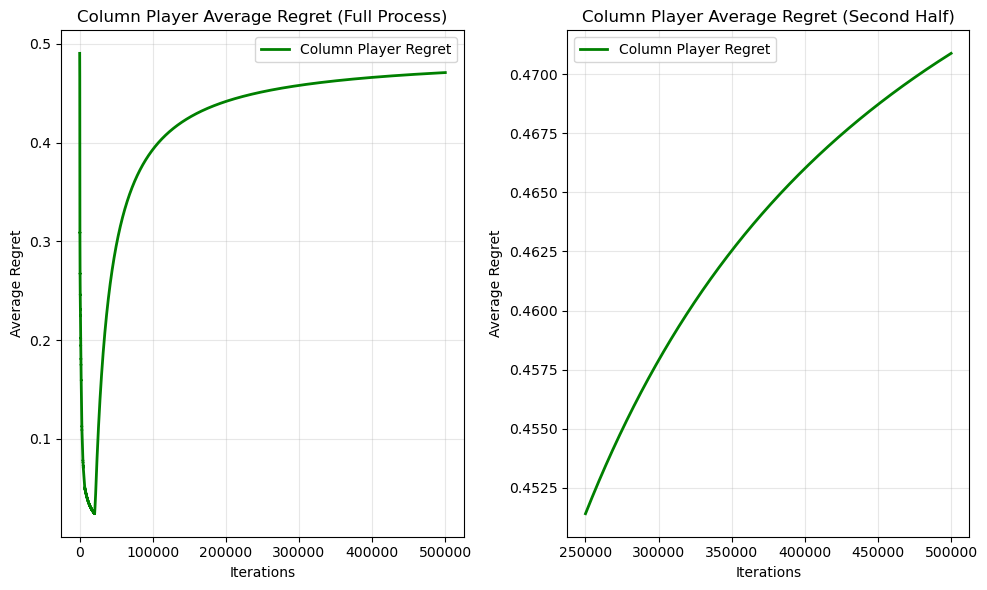

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mwu_solver import MWUNashSolver
from nash_verifier import NashVerifier
import math

def load_payoff_matrix(filepath):
    """从文本文件加载收益矩阵"""
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            row = list(map(float, line.split()))
            data.append(row)
    return np.array(data)

def test_all_games():
    """测试数据集中的所有博弈"""
    game_files = [
        "rock_paper_scissors.txt",
        "random_5x5.txt", 
        "random_10x10.txt"
    ]
    
    results = {}
    
    for filename in game_files:
        print(f"\n{'='*60}")
        print(f"测试 {filename}")
        print(f"{'='*60}")
        
        # 加载收益矩阵
        filepath = os.path.join("dataset", filename)
        payoff_matrix = load_payoff_matrix(filepath)
        
        print(f"博弈规模: {payoff_matrix.shape}")
        print(f"收益矩阵:\n{payoff_matrix}")
        
        # 根据博弈大小调整参数
        n, m = payoff_matrix.shape
        max_iter = 500000 # 可以按需修改
        epsilon = np.sqrt(math.log(n) / max_iter)
        
        solver = MWUNashSolver(payoff_matrix, epsilon=epsilon, max_iter=max_iter)
        row_strategy, col_strategy = solver.find_equilibrium()
        
        game_value = row_strategy @ payoff_matrix @ col_strategy
        row_payoff = payoff_matrix @ col_strategy
        row_best_payoff = np.max(row_payoff)
        
        print(f"\n结果:")
        print(f"  行玩家策略: {np.array_str(row_strategy, precision=6, suppress_small=True)}")
        print(f"  列玩家策略: {np.array_str(col_strategy, precision=6, suppress_small=True)}")
        print(f"  博弈值: {game_value:.6f}")
        
        # 验证是否为纳什均衡
        verifier = NashVerifier(payoff_matrix)
        is_valid = verifier.is_equilibrium(row_strategy, col_strategy)
        print(f"  Valid Nash Equilibrium: {'Yes' if is_valid else 'No'}")
        
        # 保存结果
        results[filename] = {
            'payoff_matrix': payoff_matrix,
            'row_strategy': row_strategy,
            'col_strategy': col_strategy,
            'game_value': game_value,
            'solver': solver,
            'is_valid_equilibrium': is_valid
        }
        
        # 绘制收敛图
        print(f"\n绘制 {filename} 的收敛图:")
        solver.plot_convergence(figsize=(10, 6))
    
    return results

# 运行所有测试
all_results = test_all_games()